In [64]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

In [65]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/ab_data.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [67]:
#Checking missing values
df.isnull().sum()
len(df)

294478

There are no missing values. Now, we will calculate the ideal sample size for each group. We have selected power value 80% (The probability of correctly rejecting the null hypothesis when it is false.)

In [68]:
import math
#Expected conversion rate
p1=0.13
p2=0.15

#calculate effect size
effect_size=sms.proportion_effectsize(p1,p2)

required_n=sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05, #Significance level
    ratio=1)


required_n= math.ceil(required_n)
print(f"The required size per group - {required_n}")


The required size per group - 4720


In [69]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [70]:
df['group'].dtypes

dtype('O')

In [71]:
# Check if all control group users are seeing the old page
control_page_check = df[df['group'] == 'control']['landing_page'].value_counts()

# Check if all treatment group users are seeing the new page
treatment_page_check = df[df['group'] == 'treatment']['landing_page'].value_counts()

print("Control Group Page Assignment:")
print(control_page_check)

print("Treatment Group Page Assignment:")
print(treatment_page_check)

Control Group Page Assignment:
landing_page
old_page    145274
new_page      1928
Name: count, dtype: int64
Treatment Group Page Assignment:
landing_page
new_page    145311
old_page      1965
Name: count, dtype: int64


Now we will check number of users who have been sampled multiple times

In [72]:
#Check sample_count

sample_count=df.user_id.value_counts(ascending=False)
multi_sampleCount=sample_count[sample_count>1].count()
print(f"There are {multi_sampleCount} users who have been sampled multiple times")

There are 3894 users who have been sampled multiple times


We will drop these 3894 users

In [73]:
#Drop users who have been smapled multiple times
user_index= sample_count[sample_count>1].index
df=df[~df.user_id.isin(user_index)]
df.shape

(286690, 5)

In [74]:

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test_d = pd.concat([control_sample, treatment_sample], axis=0)
ab_test_d.reset_index(drop=True, inplace=True)

In [75]:
print(ab_test_d[['group', 'landing_page']].value_counts())

group      landing_page
control    old_page        4720
treatment  new_page        4720
Name: count, dtype: int64


We tried to get an overview of the data distribution and central tendencies for both groups.

In [76]:
print(ab_test_d.groupby('group')['converted'].describe())

            count      mean       std  min  25%  50%  75%  max
group                                                         
control    4720.0  0.123305  0.328822  0.0  0.0  0.0  0.0  1.0
treatment  4720.0  0.125636  0.331473  0.0  0.0  0.0  0.0  1.0


Now we will calculate conversion rate for each group

In [77]:
# Calculate the number of conversions and sample sizes
control_conversions = ab_test_d[ab_test_d['group'] == 'control']['converted'].sum()
treatment_conversions = ab_test_d[ab_test_d['group'] == 'treatment']['converted'].sum()

control_size = ab_test_d[ab_test_d['group'] == 'control'].shape[0]
treatment_size = ab_test_d[ab_test_d['group'] == 'treatment'].shape[0]

# Calculate conversion rates
conversion_rate_control = control_conversions / control_size
conversion_rate_treatment = treatment_conversions / treatment_size

# Print results
print(f"Control Group Conversion Rate: {conversion_rate_control:.4f}")
print(f"Treatment Group Conversion Rate: {conversion_rate_treatment:.4f}")

Control Group Conversion Rate: 0.1233
Treatment Group Conversion Rate: 0.1256


In [78]:
#Z test
from statsmodels.stats.proportion import proportions_ztest
# Perform proportions z-test
counts = [control_conversions, treatment_conversions]
nobs = [control_size, treatment_size]

z_stat, p_val = proportions_ztest(counts, nobs)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

Z-statistic: -0.3430
P-value: 0.7316


In [79]:
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

control_metric = ab_test_d[ab_test_d['group'] == 'control']['converted']
treatment_metric = ab_test_d[ab_test_d['group'] == 'treatment']['converted']

t_stat, p_val = stats.ttest_ind(control_metric, treatment_metric)

# Calculate 95% confidence intervals for conversion rates
control_ci = proportion_confint(control_conversions, control_size, alpha=0.05, method='wilson')
treatment_ci = proportion_confint(treatment_conversions, treatment_size, alpha=0.05, method='wilson')
print(f"T-statistic: {t_stat:.6f}, P-value: {p_val}")

print(f"Control Group Conversion Rate: {conversion_rate_control:.4f}")
print(f"95% CI for Control Group: {control_ci}")

print(f"Treatment Group Conversion Rate: {conversion_rate_treatment:.4f}")
print(f"95% CI for Treatment Group: {treatment_ci}")

T-statistic: -0.342922, P-value: 0.7316649756550551
Control Group Conversion Rate: 0.1233
95% CI for Control Group: (0.11423046504442928, 0.13299236599280143)
Treatment Group Conversion Rate: 0.1256
95% CI for Treatment Group: (0.11648357754676986, 0.13539648007009558)


**Interpretation**

P-value:

The p-value of 0.7317 is much higher than common significance levels (e.g., 0.05 or 0.01). This suggests that there is no statistically significant difference between the control and treatment groups for the metric we analyzed.

Z-statistic and T-statistic:

Both the z-statistic and t-statistic are very close to zero, indicating that the observed difference in metrics between the control and treatment groups is minimal.

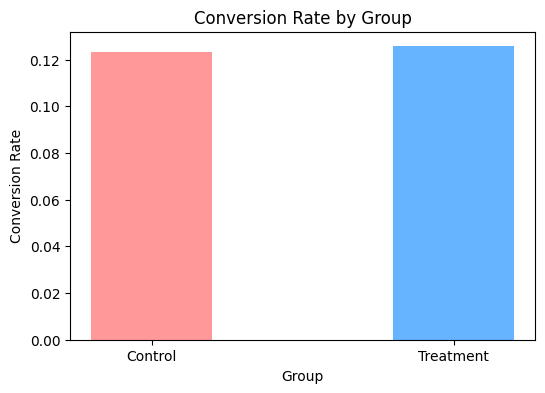

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
data = {
    'Group': ['Control', 'Treatment'],
    'Conversion Rate': [conversion_rate_control, conversion_rate_treatment]
}
df_conversion = pd.DataFrame(data)

# Set up the matplotlib figure
plt.figure(figsize=(6, 4))

# Create a bar plot using matplotlib
plt.bar(df_conversion['Group'], df_conversion['Conversion Rate'], width=0.4, color=['#ff9999','#66b3ff'])

# Add titles and labels
plt.title('Conversion Rate by Group')
plt.xlabel('Group')
plt.ylabel('Conversion Rate')

# Display the plot
plt.show()

**Conversion Rates:**

The conversion rates for the control and treatment groups are very close to each other.
The confidence intervals for both groups overlap significantly, suggesting that there is no substantial difference between the conversion rates of the two groups.

**Statistical Tests:**

Both the Z-test and T-test have high p-values (around 0.73), which is much greater than the typical significance level of 0.05. This means that we fail to reject the null hypothesis.
Conclusion from Tests: There is no statistically significant difference in conversion rates between the control and treatment groups.

**Overall Conclusion**

**Effectiveness of Treatment:** Based on the analysis, the treatment (new page) does not show a statistically significant improvement in conversion rates compared to the control (old page).

**Recommendation:** Given that the p-values are high and the confidence intervals overlap, it suggests that the new page might not have a significant impact on conversions. Further experimentation or analysis might be needed to explore other potential factors or improvements.